# Summary

Lets fit the models to the actual data.

---
# Setup

In [ ]:
# @title Imports
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


from popy.simulation_tools import *
from popy.io_tools import load_behavior
from popy.behavior_data_tools import *

from simulation_helpers import simulate_agent, estimate_ll
from plotting_helpers import *


In [ ]:
# data loading

def get_data_custom(monkey):
    behav_monkey = load_behavior(monkey)
    behav_monkey = drop_time_fields(behav_monkey)
    behav_monkey = add_switch_info(behav_monkey)
    behav_monkey = convert_column_format(behav_monkey, original='behavior')

    behav_monkey = behav_monkey.dropna()

    return behav_monkey


---
# Load behavior

In [ ]:
monkey = 'ka'

behav_monkey = get_data_custom(monkey)
#behav_monkey = pd.read_pickle('results/behavior_strategic_reset.pkl')

behav_monkey.head()

,monkey,session,trial_id,block_id,best_arm,action,reward,switch
1,ka,010720,1,0,1,2.0,0.0,0.0
2,ka,010720,2,0,1,0.0,1.0,1.0
3,ka,010720,3,0,1,0.0,0.0,0.0
4,ka,010720,4,0,1,2.0,1.0,1.0
5,ka,010720,5,0,1,2.0,0.0,0.0


# Create environment

In [ ]:
# Create the environment
env = gym.make("zsombi/monkey-bandit-task-v0", n_arms=3, max_episode_steps=100_000)

# Set container (to collect pandas series into a dataframe)
results = {}
behaviors_simulated = {f'MONKEY {monkey.upper()}': behav_monkey}

---
# Fit models to the data

## 0. Baselines

### Repeating agent

An agent that repeats the previous action. Uses Softmax to choose the action.

epsilon            0.154596
LL_best        -9458.891346
BIC_best       18927.863280
LPT_best           0.672883
LL_CV          -3168.647589
LL_std           249.998928
BIC_CV          6346.277154
BIC_std          499.997915
LPT_CV             0.671780
LPT_std            0.021134
Reward rate        0.400210
Proba best         0.325990
dtype: float64

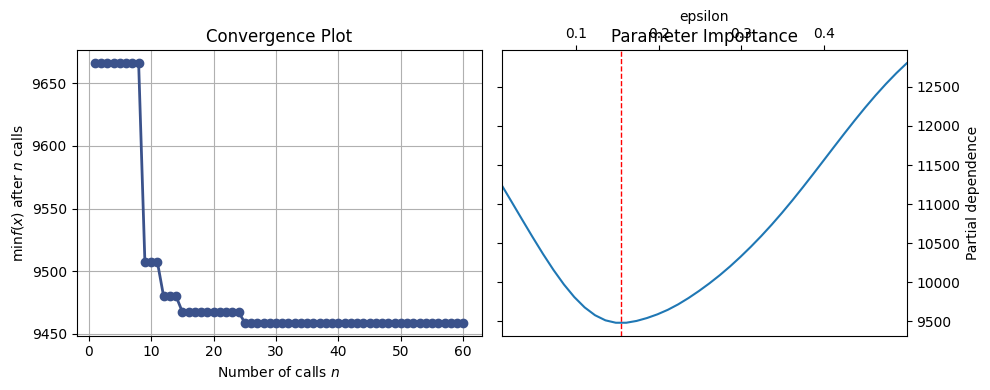

In [ ]:
# Define parameter space for ShiftValueAgent
model_name = 'Repeating agent'
agent_class = RepeatingAgent

param_space = [
    Real(0.01, 0.5, name='epsilon'),
]

fixed_params = {}

# fit agent, get best params and simulation
res_temp, behavior_temp = fit_simulate(agent_class, param_space,env, behav_monkey, fixed_params, CV_splits=3, make_plots=True, n_calls=60, n_initial_points=10, n_jobs=1)
results[model_name] = res_temp
behaviors_simulated[model_name] = behavior_temp

res_temp

### Simple WSLS

### Modified WSLS

epsilon            0.118323
LL_best        -8746.160388
BIC_best       17502.401363
LPT_best           0.693273
LL_CV          -2920.734947
LL_std           285.841305
BIC_CV          5850.451869
BIC_std          571.682669
LPT_CV             0.693107
LPT_std            0.024962
Reward rate        0.494640
Proba best         0.571740
dtype: float64

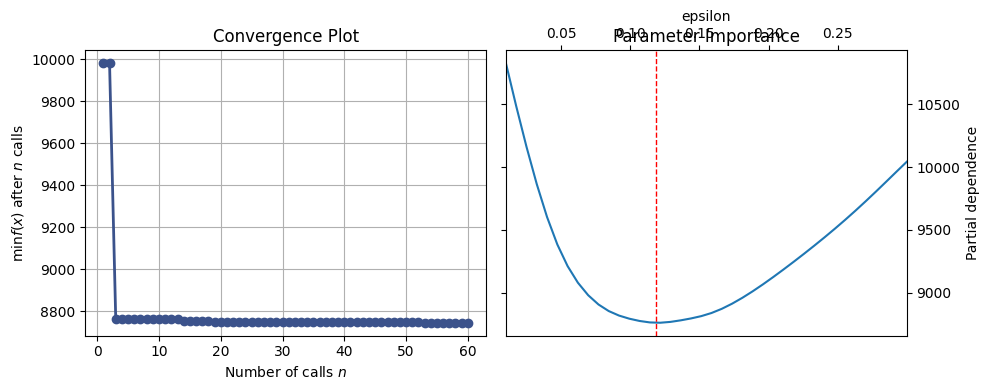

In [ ]:
# Define parameter space for ShiftValueAgent
model_name = 'WSLS agent (long history)'
agent_class = WSLSAgent_custom

param_space = [
    Real(.01, .3, name='epsilon'),
]

fixed_params = {}

res_temp, behavior_temp = fit_simulate(agent_class, param_space, env, behav_monkey, fixed_params, CV_splits=3, make_plots=True, n_calls=60, n_initial_points=10)
results[model_name] = res_temp
behaviors_simulated[model_name] = behavior_temp

res_temp

## 1. RL

### Simple RL agent

alpha              0.520125
beta               7.741785
LL_best        -9229.665383
BIC_best       18479.491940
LPT_best           0.679374
LL_CV          -3080.253395
LL_std           219.033258
BIC_CV          6178.470740
BIC_std          438.066524
LPT_CV             0.679230
LPT_std            0.018713
Reward rate        0.541820
Proba best         0.699560
dtype: float64

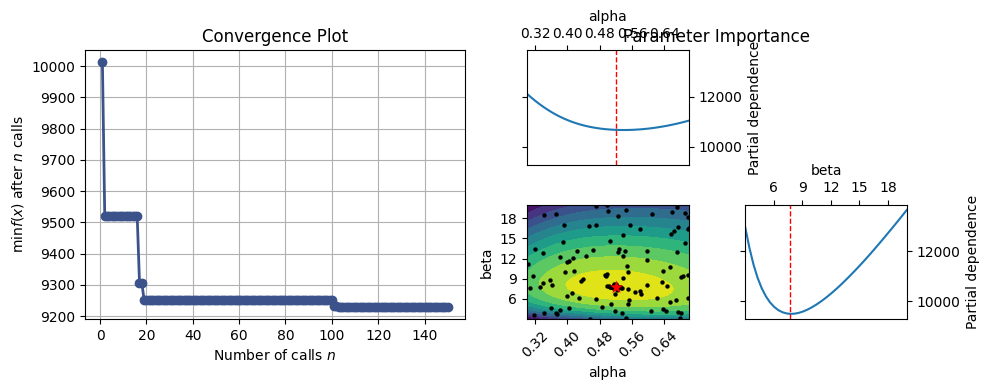

In [ ]:
# Define parameter space for ShiftValueAgent
agent_class = QLearner
model_name = 'Q-Learner'

param_space = [
    Real(0.3, .7, name='alpha'),
    Real(3, 20.0, name='beta'),
]

fixed_params = {
    'structure_aware': False
}

res_temp, behavior_temp = fit_simulate(agent_class, param_space, env, behav_monkey, fixed_params, CV_splits=3, make_plots=True, n_calls=150, n_initial_points=100)
results[model_name] = res_temp
behaviors_simulated[model_name] = behavior_temp

res_temp

### Counterfactual

alpha              0.126560
beta               8.707655
LL_best       -12833.446766
BIC_best       25687.054706
LPT_best           0.584191
LL_CV          -4285.307744
LL_std           343.256256
BIC_CV          8588.579437
BIC_std          686.512601
LPT_CV             0.584007
LPT_std            0.025452
Reward rate        0.539530
Proba best         0.699340
dtype: float64

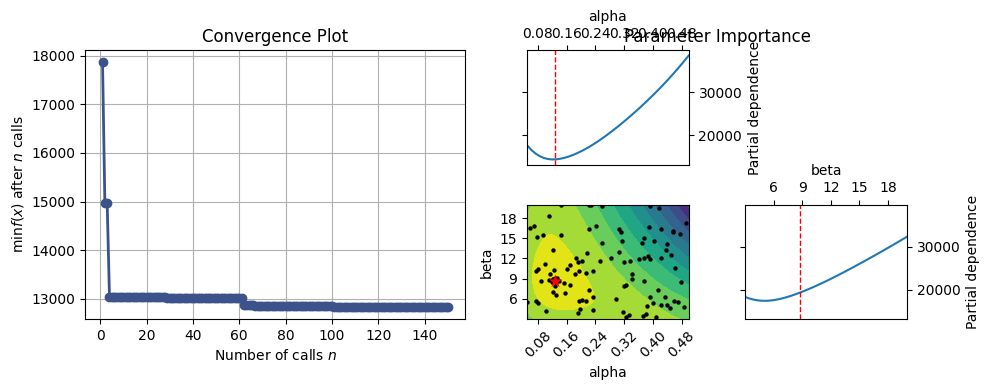

In [ ]:
# Define parameter space for ShiftValueAgent
agent_class = QLearner
model_name = 'Q-Learner counterfactual'

param_space = [
    Real(0.05, .5, name='alpha'),
    Real(3, 20.0, name='beta'),
]

fixed_params = {
    'structure_aware': True
}

res_temp, behavior_temp = fit_simulate(agent_class, param_space, env, behav_monkey, fixed_params, CV_splits=3, make_plots=True, n_calls=150, n_initial_points=100)
results[model_name] = res_temp
behaviors_simulated[model_name] = behavior_temp

res_temp

### Multiple learning rates

In [ ]:
'''# Define parameter space for ShiftValueAgent
agent_class = QLearner
model_name = 'Q-Learner multiple alphas'

param_space = [
    Real(0.01, .6, name='alpha'),
    Real(0.01, .3, name='alpha_unchosen'),
    Real(3, 20.0, name='beta'),
]

fixed_params = {
    'structure_aware': True
}

res_temp, behav_q_learn_multiple = fit_simulate(agent_class, param_space, env, behav_monkey, fixed_params, 
                                                model_name, make_plots=True,  verbose=False,
                                               n_calls=150, n_initial_points=100)
results_list.append(res_temp)
behaviors_simulated[model_name] = behav_q_learn_multiple'''

"# Define parameter space for ShiftValueAgent\nagent_class = QLearner\nmodel_name = 'Q-Learner multiple alphas'\n\nparam_space = [\n    Real(0.01, .6, name='alpha'),\n    Real(0.01, .3, name='alpha_unchosen'),\n    Real(3, 20.0, name='beta'),\n]\n\nfixed_params = {\n    'structure_aware': True\n}\n\nres_temp, behav_q_learn_multiple = fit_simulate(agent_class, param_space, env, behav_monkey, fixed_params, \n                                                model_name, make_plots=True,  verbose=False,\n                                               n_calls=150, n_initial_points=100)\nresults_list.append(res_temp)\nbehaviors_simulated[model_name] = behav_q_learn_multiple"

## 2. Shift value

### No reset

alpha              0.435319
beta              10.355439
V0                 0.116635
LL_best        -5816.688678
BIC_best       11663.619117
LPT_best           0.783777
LL_CV          -1941.031240
LL_std           188.423959
BIC_CV          3909.008405
BIC_std          376.848083
LPT_CV             0.783714
LPT_std            0.018612
Reward rate        0.545640
Proba best         0.705220
dtype: float64

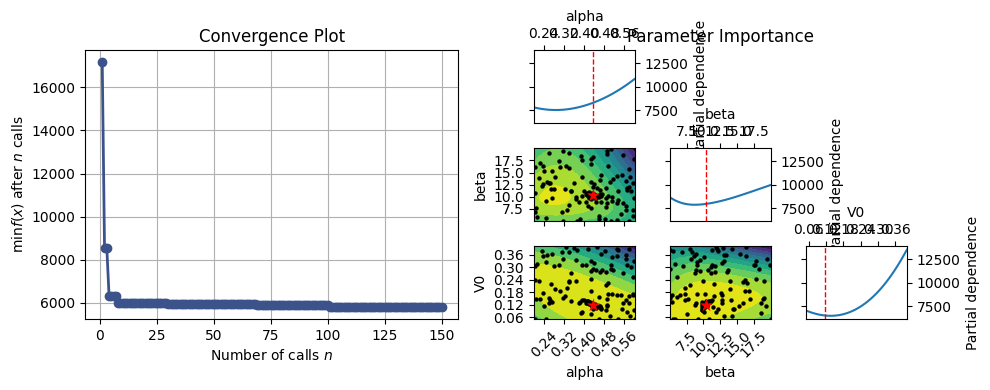

In [ ]:
# Define parameter space for ShiftValueAgent
agent_class = ShiftValueAgent
model_name = 'Shift-value agent'

param_space = [
    Real(0.2, 0.6, name='alpha'),
    Real(5, 20.0, name='beta'),
    Real(0.05, .4, name='V0')
]

fixed_params = {
    'reset_on_switch': False
}

res_temp, behavior_temp = fit_simulate(agent_class, param_space, env, behav_monkey, fixed_params, CV_splits=3, make_plots=True, n_calls=150, n_initial_points=100)
results[model_name] = res_temp
behaviors_simulated[model_name] = behavior_temp

res_temp

### Reset

alpha              0.405287
beta              10.604318
V0                 0.122051
LL_best        -5680.792421
BIC_best       11391.826603
LPT_best           0.788251
LL_CV          -1899.084383
LL_std           183.943624
BIC_CV          3825.114690
BIC_std          367.887394
LPT_CV             0.787849
LPT_std            0.018296
Reward rate        0.548210
Proba best         0.721270
dtype: float64

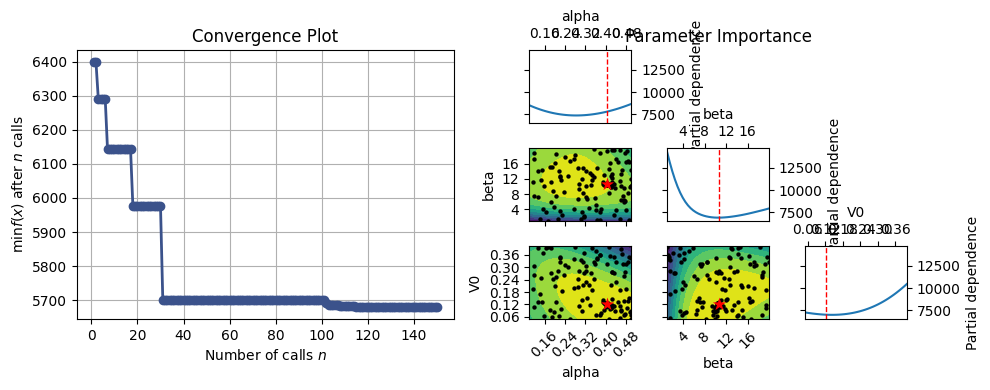

In [ ]:
# Define parameter space for ShiftValueAgent
agent_class = ShiftValueAgent
model_name = 'Shift-value agent with reset'

param_space = [
    Real(0.1, 0.5, name='alpha'),
    Real(1, 20.0, name='beta'),
    Real(0.05, .4, name='V0')
]

fixed_params = {
    'reset_on_switch': True
}

res_temp, behavior_temp = fit_simulate(agent_class, param_space, env, behav_monkey, fixed_params, CV_splits=3, make_plots=True, n_calls=150, n_initial_points=100)
results[model_name] = res_temp
behaviors_simulated[model_name] = behavior_temp

res_temp

---
### Save Shift-value simulation

In [ ]:
'''# show value function vs proba shift for threshold model
params = {'alpha': res_shift_threshold['alpha'], 'beta': res_shift_threshold['beta'], 'V0': res_shift_threshold['V0']}

fixed_params = {'reset_on_switch': True}
simulation = simulate_agent(ShiftValueAgent,
                            params=params,
                            env=env,
                            fixed_params={'reset_on_switch': True},
                            behavioral_variables=['Q'],
                            n_trials=len(behav_monkey))
                            
simulation = convert_column_format(simulation, original='simulation')

simulation['monkey'] = f'simulation_{monkey}'  # add change from 'simulation' to 'simulation_monkey' for plotting
simulation = simulation.rename(columns={'Q': 'value_function'})

# add metadata to the behav dataframe
simulation.attrs['model'] = 'Shift-value agent with reset'
simulation.attrs['parameters'] = params
simulation.attrs['fixed_parameters'] = fixed_params

from popy.config import PROJECT_PATH_LOCAL
floc = os.path.join(PROJECT_PATH_LOCAL, 'data', 'processed', 'behavior', f'simulation_{monkey}.pkl')
simulation.to_pickle(floc)
simulation'''

"# show value function vs proba shift for threshold model\nparams = {'alpha': res_shift_threshold['alpha'], 'beta': res_shift_threshold['beta'], 'V0': res_shift_threshold['V0']}\n\nfixed_params = {'reset_on_switch': True}\nsimulation = simulate_agent(ShiftValueAgent,\n                            params=params,\n                            env=env,\n                            fixed_params={'reset_on_switch': True},\n                            behavioral_variables=['Q'],\n                            n_trials=len(behav_monkey))\n                            \nsimulation = convert_column_format(simulation, original='simulation')\n\nsimulation['monkey'] = f'simulation_{monkey}'  # add change from 'simulation' to 'simulation_monkey' for plotting\nsimulation = simulation.rename(columns={'Q': 'value_function'})\n\n# add metadata to the behav dataframe\nsimulation.attrs['model'] = 'Shift-value agent with reset'\nsimulation.attrs['parameters'] = params\nsimulation.attrs['fixed_parameters'] = fi

## 3. HMM

The bayes has the best parameters in principle. Also we dont go with this model, and it has a lot of parameters.

---
# Summary

## Fitting statistics

In [ ]:
res_all = pd.DataFrame.from_dict(results, orient='index').reset_index()
res_all = res_all.rename(columns={'index': 'Model'})

# remove Model=Q-Learner multiple alphas
res_all = res_all.loc[res_all['Model'].isin(['WSLS agent (long history)', 'Q-Learner', 'Q-Learner counterfactual', 'Shift-value agent with reset'])]

# save results
from popy.config import PROJECT_PATH_LOCAL
floc = os.path.join(PROJECT_PATH_LOCAL, 'notebooks', 'behav_modeling', 'results', f'simulation_results_{monkey}.pkl')
res_all.to_pickle(floc)

/var/folders/27/vz2x5s696jv_fnk5tpw5z1gw0000gn/T/ipykernel_98894/141671183.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
/var/folders/27/vz2x5s696jv_fnk5tpw5z1gw0000gn/T/ipykernel_98894/141671183.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')


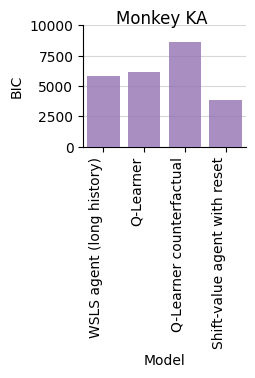

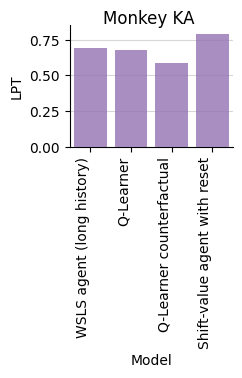

In [ ]:
# show bic and LPT values
w = 4/6*8
h = 4

color = COLORS[monkey]

for mode in ['BIC_CV', 'LPT_CV']:
    fig, ax = plt.subplots(1, 1, figsize=(w/2.54, h/2.54))

    plt.suptitle(f'Monkey {monkey.upper()}')

    # show bic and ll values side by side for each model
    sns.barplot(data=res_all, x='Model', y=mode, ax=ax, zorder=10, alpha=0.8, color=color)

    #ax.set_title('BIC scores (cross-validated)')
    ax.set_ylabel(mode.split('_')[0])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.grid(axis='y', alpha=0.5, zorder=0)

    if mode == 'BIC_CV':
        ax.set_ylim(0, 10000)
    else:
        ax.set_ylim(0, .85)
        
        # save as svg
        floc = os.path.join('figs', f'{monkey}_lpt.svg')
        plt.savefig(floc, dpi=300, bbox_inches='tight')


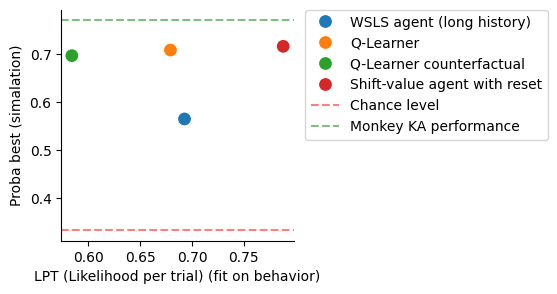

In [ ]:
# show RPT vs Proba best
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

sns.scatterplot(data=res_all, x='LPT_CV', y='Proba best', ax=ax, hue='Model', s=100)

ax.set_xlabel('LPT (Likelihood per trial) (fit on behavior)')
ax.set_ylabel('Proba best (simalation)')

ax.axhline(1/3, color='red', linestyle='--', alpha=0.5, label='Chance level')
ax.axhline(.77, color='green', linestyle='--', alpha=0.5, label='Monkey KA performance')

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#ax.set_xlim(.5, .8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


## Behavioral characteristics

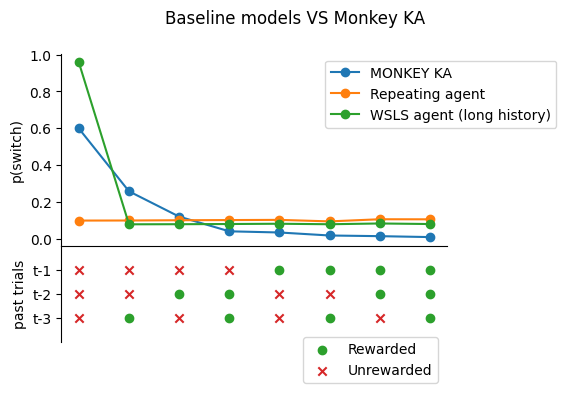

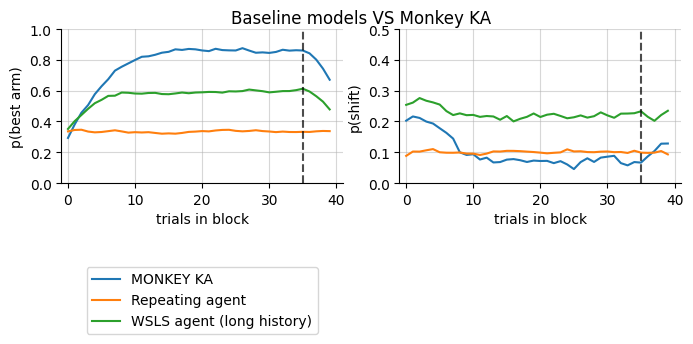

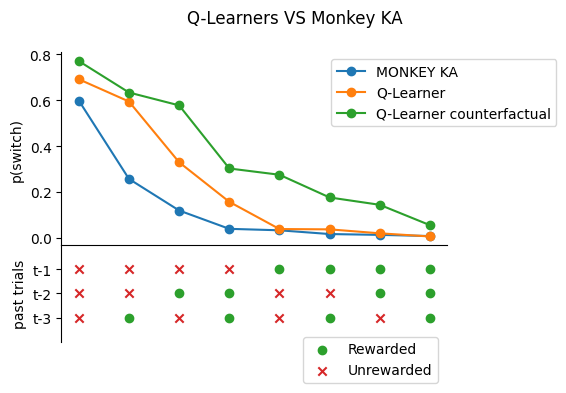

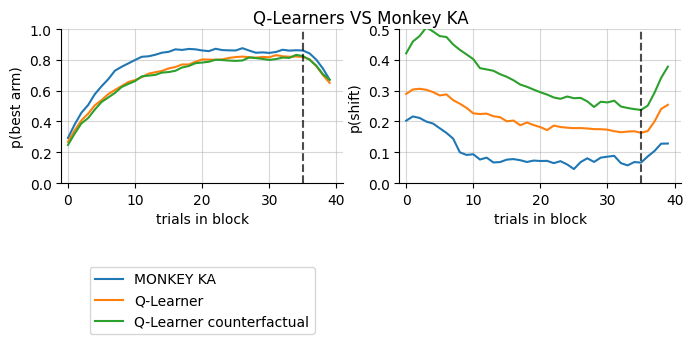

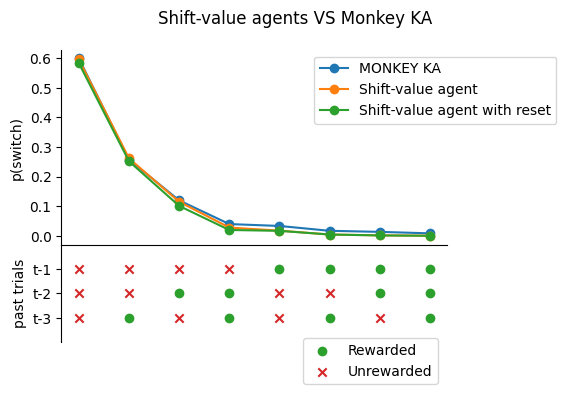

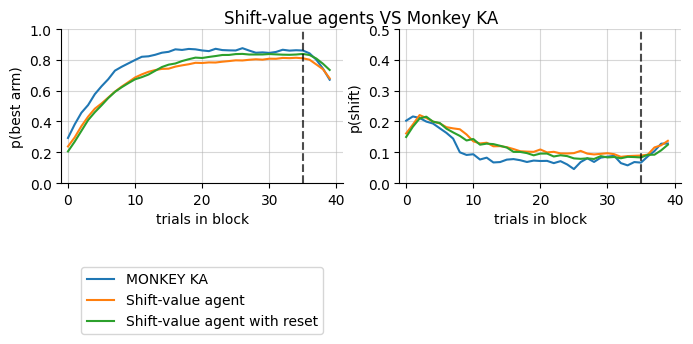

In [ ]:
# monkey vs baseline models
behav_temp = {key: value for key, value in behaviors_simulated.items() if key in [f'MONKEY {monkey.upper()}', 'Repeating agent', 'WSLS agent (long history)']}
plot_hist_thingy(behav_temp, title='Baseline models VS Monkey {}'.format(monkey.upper()))
plot_summary_stats(behav_temp, title='Baseline models VS Monkey {}'.format(monkey.upper()))

# monkey vs q-learners
behav_temp = {key: value for key, value in behaviors_simulated.items() if key in [f'MONKEY {monkey.upper()}', 'Q-Learner', 'Q-Learner counterfactual']}
plot_hist_thingy(behav_temp, title='Q-Learners VS Monkey {}'.format(monkey.upper()))
plot_summary_stats(behav_temp, title='Q-Learners VS Monkey {}'.format(monkey.upper()))

# monkey vs shift-value agents
behav_temp = {key: value for key, value in behaviors_simulated.items() if key in [f'MONKEY {monkey.upper()}', 'Shift-value agent', 'Shift-value agent with reset']}
plot_hist_thingy(behav_temp, title='Shift-value agents VS Monkey {}'.format(monkey.upper()))
plot_summary_stats(behav_temp, title='Shift-value agents VS Monkey {}'.format(monkey.upper()))
